In [311]:
import torch
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import torchvision
import random
from matplotlib import image as mpimg
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn

In [312]:
input = torch.randn(64, 10, 20, 20)
conv_trans = torch.nn.ConvTranspose2d(
    in_channels=10,
    out_channels=10,
    kernel_size=2,
    stride=2)
output = conv_trans(input)
output.shape

torch.Size([64, 10, 40, 40])

In [313]:
path = Path('./FinalTestPartTwo')
imgs = [np.array(Image.open(path/'dataset'/i)).astype(np.float32)/255. for i in os.listdir(path/'dataset')]
ixs = [i.split('_')[-1].split('.')[0] for i in os.listdir(path/'dataset')]
masks = [np.array(Image.open(path/'Segmentation'/f'Coocker_{ix}.png')).astype(np.uint8) for ix in ixs]

len(imgs), len(masks)

(1000, 1000)

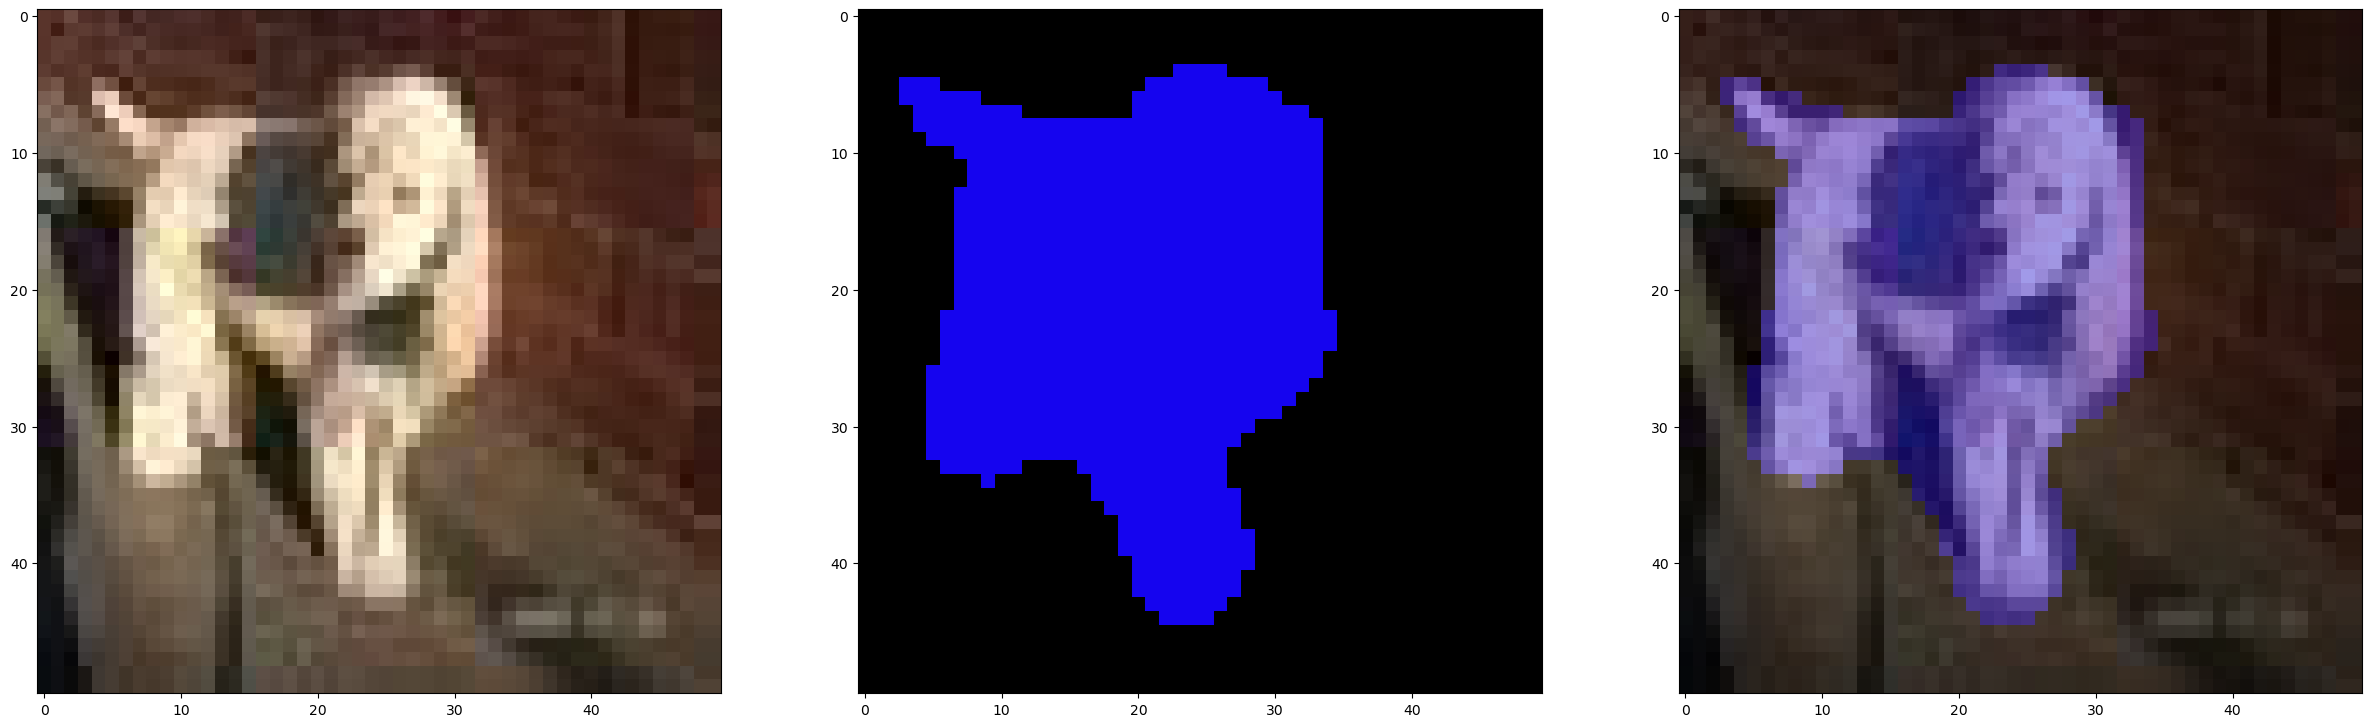

In [314]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
img = imgs[0]
mask = masks[0]
ax1.imshow(img)
ax2.imshow(mask, cmap='gray')
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

In [315]:
img.shape, img.dtype, img.max(), img.min()

((50, 50, 3), dtype('float32'), 1.0, 0.0)

In [316]:
mask.shape, mask.dtype, mask.max(), mask.min()

((50, 50, 3), dtype('uint8'), 239, 0)

In [317]:
mask_oh = (np.arange(3) == mask[..., None]).astype(np.float32)
mask_oh = mask_oh[:, :, 0, :]
mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((50, 50, 3), dtype('float32'), 1.0, 0.0)

In [318]:
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
    return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):  # Changed in_ch from 1 to 3
        super().__init__()

        c = [16, 32, 64, 128]

        self.conv1 = torch.nn.Sequential(
            conv3x3_bn(in_ch, c[0]),  # Changed in_ch from 1 to 3
            conv3x3_bn(c[0], c[0]),
        )

        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        self.deconv1 = deconv(c[3], c[2])
        self.deconv2 = deconv(c[2], c[1])
        self.deconv3 = deconv(c[1], c[0])

        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)

        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x


In [325]:
model = UNet()
output = model(torch.randn((10,3,50,50)))
output.shape

torch.Size([10, 3, 50, 50])

In [320]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

In [321]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [322]:
img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)
mask_tensor = torch.tensor(mask_oh).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape


(torch.Size([1, 1, 50, 50, 3]), torch.Size([1, 3, 50, 50]))

In [323]:
fit(model, img_tensor, mask_tensor)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 50, 50, 3]